## 1. Data preprocessing

### 1-1. Import libraries 

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torchmetrics
import torch_scatter

import Featurizer
import getFeatures

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
import copy

import numpy as np

from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import UIntSparseIntVect
import re
from gensim.models import Word2Vec

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec

### 1-2. Load data

In [2]:
# bitterdb: compound name, pubchem CID, smiles, bitterness label
bitterdb = pd.read_csv('/home/jovyan/kipi1/chaewon/scAIence/bitterness.csv')
df = bitterdb.copy()
df = df[['canonical SMILES', 'Bitterness']]
df.head()

,canonical SMILES,Bitterness
0,COc1cc(ccc1O)OC1OC(COC(=O)c2cc(c(c(c2)O)O)O)C(...,1
1,CC(C)C12CC2C(C)C(=O)C1,1
2,OC1Cc2c(cc(cc2OC1c1ccc(c(c1)O)O)O)O,1
3,Oc1cc(c2c(c1)OC(C(C2)OC(=O)c1cc(c(c(c1)O)O)O)c...,1
4,OC1Cc2c(cc(cc2OC1c1cc(c(c(c1)O)O)O)O)O,1


In [3]:
# transform smiles to mol
# there may be some smiles that cannot be converted to mol

print('before: ', len(df))
mols = [Chem.MolFromSmiles(s) for s in df['canonical SMILES']]

none_list = []
for i, mol in enumerate(mols):
    if mol is None:
        none_list.append(i)

df = df.drop(none_list)
df = df.reset_index(drop=True)
print(none_list)
print('after: ', len(df))

before:  2511
[]
after:  2511


#### 1-2-1. Chemical features

In [4]:
# make a list of QED values of molecules using RDKit
qed_list = []
for mol in mols:
    qed_list.append(Chem.QED.properties(mol))
    
# make a dataframe of QED values
qed_df = pd.DataFrame(qed_list)
qed_df.head()

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,454.384,-0.4390,12,7,195.60,6,2,2
1,152.237,2.2576,1,0,17.07,1,0,0
2,290.271,1.5461,6,5,110.38,1,2,1
3,442.376,2.5276,10,7,177.14,3,3,2
4,306.270,1.2517,7,6,130.61,1,2,1


#### 1-2-2. Physical features

In [5]:
# Make Morgan Fingerprint list
bit_info_list = [] 
bitinfo = {} 
fps = []

for mol in mols :
    fps.append(Chem.rdMolDescriptors.GetMorganFingerprint(mol, 3, bitInfo=bitinfo))


# Make a list of identifiers of atoms in Morgan Fingerprint
fp_idf = []
fp_idf_tokens = []
max_len = 0

for fp in fps:
    fp_idf.append(list(map(str, list(UIntSparseIntVect.GetNonzeroElements(fp).keys()))))
    fp_idf_tokens.extend(list(map(str, list(UIntSparseIntVect.GetNonzeroElements(fp).keys()))))
    atom_len = UIntSparseIntVect.GetTotalVal(fp)
    if atom_len > max_len:
        max_len = atom_len
    
fp_idf_tokens = list(set(fp_idf_tokens))

print(len(fp_idf))
print(len(fp_idf_tokens))
print('max_len: ', max_len)

2511
22052
max_len:  371


In [6]:
# define a model
sentences = [fp_idf_tokens]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [7]:
df = pd.concat([df, pd.DataFrame(columns=['mol2vec'])], axis=1)

In [8]:
def sentences2vec(sentence, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """
    keys = set(list(model.wv.key_to_index.keys()))
    vec = []
    # print(keys)
    if unseen:
        unseen_vec = model.wv.word_vec(unseen)


    if unseen:
        vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                    else unseen_vec for y in sentence]))
    else:
        vec.append(sum([model.wv.get_vector(y) for y in sentence 
                        if y in set(sentence) & keys]))

    return np.array(vec)

In [9]:
fp_df = pd.DataFrame(columns=['sentence'])
fp_df = pd.concat([fp_df, pd.DataFrame(columns=range(100))], axis=1)
fp_df

,sentence,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99


In [10]:
count = 0
for mol in mols:
    mol_sen = MolSentence(mol2alt_sentence(mol, 1))
    mol_vec = sentences2vec(mol_sen, model=model, unseen=None)
    # fp_df = fp_df.append({'sentence': mol_sen, 'mol2vec': mol_vec}, ignore_index=True)
    fp_df = fp_df.append({'sentence': mol_sen}, ignore_index=True)
    
    # # add mol2vec to fp_df2
    fp_df.iloc[count, 1:] = list(mol_vec[0])
    count += 1
    
fp_df.head()

,sentence,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,"(2246728737, 3975275337, 864674487, 2076190208...",-0.163545,-0.140058,-0.050965,-0.078738,0.013594,-0.024655,0.092669,0.10904,0.099937,...,0.016983,0.024776,0.088294,-0.007048,-0.162872,-0.007921,0.106107,0.013475,-0.128641,-0.127145
1,"(2246728737, 3537119515, 2245273601, 896700566...",-0.000904,-0.074254,0.019742,-0.048442,-0.007241,0.018508,0.005953,0.015647,-0.036477,...,-0.028809,0.00687,0.031939,-0.038443,-0.048996,0.06083,0.013975,0.015101,0.020891,0.028612
2,"(864662311, 266675433, 2976033787, 1228528465,...",-0.110109,-0.107989,-0.109432,-0.059347,0.016035,-0.027629,0.071291,0.09138,0.162024,...,0.049357,0.016159,0.13342,-0.002712,-0.111622,-0.044186,0.083688,-0.004813,-0.047933,-0.094015
3,"(864662311, 26234434, 3217380708, 2905660137, ...",-0.213715,-0.163939,-0.175804,-0.059363,-0.012055,-0.016048,0.090878,0.117469,0.257707,...,0.069146,0.033816,0.195374,-0.03041,-0.173037,-0.1037,0.093532,-0.02937,-0.056331,-0.171606
4,"(864662311, 266675433, 2976033787, 1228528465,...",-0.128392,-0.111134,-0.110598,-0.067026,0.010968,-0.033032,0.056393,0.090908,0.168271,...,0.073411,-0.004027,0.139743,0.002366,-0.126889,-0.052345,0.04148,-0.027987,-0.053655,-0.117215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,"(2246728737, 3545365497, 2246699815, 266499585...",-0.060527,-0.106197,-0.077433,-0.031387,0.040009,-0.08012,0.088717,0.039407,-0.039796,...,-0.085252,-0.009295,0.004822,-0.0329,-0.050219,0.126966,0.027993,-0.001258,0.078199,-0.005601
2507,"(2246728737, 3545365497, 2246699815, 266499585...",-0.099616,-0.143056,-0.030806,-0.087321,0.028975,0.080665,0.082016,-0.002362,-0.053926,...,-0.024573,0.021898,-0.053202,-0.003767,-0.061812,0.136646,0.015286,0.054695,0.028479,0.038866
2508,"(2246728737, 3975275337, 864674487, 2076190208...",0.019282,-0.007555,-0.088831,-0.069328,-0.000886,-0.021208,0.063566,0.03358,0.098567,...,-0.091869,0.044695,0.036365,-0.04498,-0.098511,-0.029888,0.079708,0.054446,-0.050692,0.070841
2509,"(2246728737, 3975275337, 864674487, 2076190208...",-0.023797,-0.023473,-0.102829,-0.053465,0.023082,-0.003919,0.064493,0.035541,0.110674,...,-0.071293,0.056289,0.042493,-0.033949,-0.112613,-0.04751,0.079079,0.064702,-0.052131,0.049758


#### 1-2-3. Make Physicochemical features

In [13]:
# concatenate bitterdb and qed_df
label = df['Bitterness']
df = pd.concat([df['canonical SMILES'], qed_df, fp_df, label], axis=1)
df.head()

,canonical SMILES,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,sentence,...,91,92,93,94,95,96,97,98,99,Bitterness
0,COc1cc(ccc1O)OC1OC(COC(=O)c2cc(c(c(c2)O)O)O)C(...,454.384,-0.4390,12,7,195.60,6,2,2,"(2246728737, 3975275337, 864674487, 2076190208...",...,0.024776,0.088294,-0.007048,-0.162872,-0.007921,0.106107,0.013475,-0.128641,-0.127145,1
1,CC(C)C12CC2C(C)C(=O)C1,152.237,2.2576,1,0,17.07,1,0,0,"(2246728737, 3537119515, 2245273601, 896700566...",...,0.00687,0.031939,-0.038443,-0.048996,0.06083,0.013975,0.015101,0.020891,0.028612,1
2,OC1Cc2c(cc(cc2OC1c1ccc(c(c1)O)O)O)O,290.271,1.5461,6,5,110.38,1,2,1,"(864662311, 266675433, 2976033787, 1228528465,...",...,0.016159,0.13342,-0.002712,-0.111622,-0.044186,0.083688,-0.004813,-0.047933,-0.094015,1
3,Oc1cc(c2c(c1)OC(C(C2)OC(=O)c1cc(c(c(c1)O)O)O)c...,442.376,2.5276,10,7,177.14,3,3,2,"(864662311, 26234434, 3217380708, 2905660137, ...",...,0.033816,0.195374,-0.03041,-0.173037,-0.1037,0.093532,-0.02937,-0.056331,-0.171606,1
4,OC1Cc2c(cc(cc2OC1c1cc(c(c(c1)O)O)O)O)O,306.270,1.2517,7,6,130.61,1,2,1,"(864662311, 266675433, 2976033787, 1228528465,...",...,-0.004027,0.139743,0.002366,-0.126889,-0.052345,0.04148,-0.027987,-0.053655,-0.117215,1


In [12]:
# check the number of null values
df.isnull().sum()

canonical SMILES    0
MW                  0
ALOGP               0
HBA                 0
HBD                 0
                   ..
96                  0
97                  0
98                  0
99                  0
Bitterness          0
Length: 111, dtype: int64

In [14]:
df.to_csv('physicochemical_features_morganFP_word2vec.csv', index=False)

### 1-3. Data visualization

In [15]:
%matplotlib inline

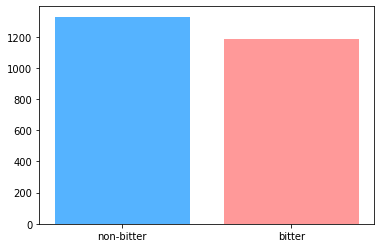

In [16]:
plt.bar(df['Bitterness'].value_counts().index, df['Bitterness'].value_counts().values, color=['#55b3ff', '#ff9999'])
plt.xticks([0, 1], ['non-bitter', 'bitter'])
plt.show()

## 2. Make datasets and Model Training

### 2-1. Make datasets

In [21]:
df = pd.read_csv('physicochemical_features_morganFP_word2vec.csv')
can_SMILES = df['canonical SMILES']
df = df.drop(['canonical SMILES', 'sentence'], axis=1)
df.head()

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS,0,1,...,91,92,93,94,95,96,97,98,99,Bitterness
0,454.384,-0.4390,12,7,195.60,6,2,2,-0.163545,-0.140058,...,0.024776,0.088294,-0.007048,-0.162872,-0.007921,0.106107,0.013475,-0.128641,-0.127145,1
1,152.237,2.2576,1,0,17.07,1,0,0,-0.000904,-0.074254,...,0.006870,0.031939,-0.038443,-0.048996,0.060830,0.013975,0.015101,0.020891,0.028612,1
2,290.271,1.5461,6,5,110.38,1,2,1,-0.110109,-0.107989,...,0.016159,0.133420,-0.002712,-0.111622,-0.044186,0.083688,-0.004813,-0.047933,-0.094015,1
3,442.376,2.5276,10,7,177.14,3,3,2,-0.213715,-0.163939,...,0.033816,0.195374,-0.030410,-0.173038,-0.103700,0.093532,-0.029370,-0.056331,-0.171606,1
4,306.270,1.2517,7,6,130.61,1,2,1,-0.128392,-0.111134,...,-0.004027,0.139743,0.002366,-0.126889,-0.052345,0.041480,-0.027987,-0.053655,-0.117215,1


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Columns: 109 entries, MW to Bitterness
dtypes: float64(103), int64(6)
memory usage: 2.1 MB


In [23]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [24]:
train_df.to_csv('~/kipi1/chaewon/scAIence/code/physicochemical_features_train_word2vec.csv')
test_df.to_csv('~/kipi1/chaewon/scAIence/code/physicochemical_features_test_word2vec.csv')

In [63]:
class CustomDataset(Dataset):
    def __init__(self, data, target='Bitterness', norm=True):
        super(CustomDataset, self).__init__()
        
        self.x = data.drop(target, axis=1)
        self.x_chem = data[['MW', 'ALOGP', 'HBA', 'HBD', 'PSA', 'AROM', 'ALERTS']].reset_index(drop=True)
        self.x_fp = data.drop(['MW', 'ALOGP', 'HBA', 'HBD', 'PSA', 'AROM', 'ALERTS', 'Bitterness'], axis=1).reset_index(drop=True)
        
        if norm:
            self.x_chem = pd.DataFrame(normalize(self.x_chem, norm='l2', axis=0), columns=self.x_chem.columns)
            self.x = pd.concat([self.x_chem, self.x_fp], axis=1, ignore_index=True)

        self.y = data[target]

        
        self.x = torch.tensor(self.x.values).float()
        self.y = torch.tensor(self.y.values).float()
        print(self.x.shape)
        print(self.y.shape)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        return x, y

In [64]:
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

torch.Size([2008, 108])
torch.Size([2008])
torch.Size([503, 108])
torch.Size([503])


In [65]:
BATCH_SIZE = 64
NUM_FEATURES = len(df.drop('Bitterness', axis=1).columns)
EPOCH = 300
LR = 0.0001

In [66]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### 2-2. Build a model

In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [68]:
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(num_features, 64)
        self.bn1 = nn.BatchNorm1d(64)

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)   
        
        self.dropout3 = nn.Dropout(0.2)  
          
        # self.fc4 = nn.Linear(64, 32)
        # self.bn4 = nn.BatchNorm1d(32)  
        
        # self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)

        
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        
        x = self.dropout3(x)
        
        # x = F.relu(self.fc4(x))
        # x = self.bn4(x)
        
        # x = self.dropout4(x)
        
        x = self.fc5(x)
        y = torch.sigmoid(x)
        
        
        return x, y

In [81]:
model = Net(NUM_FEATURES).to(device)
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
saved_path = "/home/jovyan/kipi1/chaewon/scAIence/code/chemical_model_path"
model

Net(
  (fc1): Linear(in_features=108, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)

### 2-3. Model training

In [83]:
losses = []
acces = []

val_losses = []
val_acces = []

best_loss = 1000000
patience_counter = 0
patience_limit = 7
accuracy = torchmetrics.Accuracy(num_classes=2)

for epoch in range(EPOCH):
    running_loss = 0
    running_acc = 0
    total_samples = 0  # Add a variable to keep track of the total number of samples
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        vec, out = model(x)
        loss = loss_func(out.view(-1).unsqueeze(1), y.unsqueeze(1))
        # print(loss)        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += torch.sum(out.round() == y.unsqueeze(1)).item()  # Update the running_acc calculation
        total_samples += len(y)  # Update the total_samples count
        
    loss = running_loss / len(train_loader)
    acc = running_acc / total_samples
    losses.append(loss)
    acces.append(acc)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.4f}")
    
    model.eval()

    with torch.no_grad():
        val_loss = 0
        val_acc = 0
        total = 0
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            vec, out = model(x)
            loss = loss_func(out.view(-1).unsqueeze(1), y.unsqueeze(1))
            
            val_loss += loss.item()
            val_acc += torch.sum(out.round() == y.unsqueeze(1)).item()  # Update the val_acc calculation
            total += y.size(0)
            
            
        val_loss = val_loss / len(test_loader)
        val_acc = val_acc / total  # Fix the calculation of val_acc
        val_losses.append(val_loss)
        val_acces.append(val_acc)
        
                
        
        if val_loss > best_loss:
            patience_counter +=1
            if patience_counter >= patience_limit:
                print('Early Stopping')
                break
        else:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'{saved_path}/best_checkpoint_epoch_{epoch + 1}.pth')
        
        
        if epoch % 10 == 0:
            print(f"epoch: {epoch}, train_loss: {round(losses[-1], 3)}, train_acc: {round(acces[-1], 3)}, val_loss: {round(val_loss/len(test_loader), 3)}, val_acc: {round(val_acc, 3)}")

print('Finished Training')
print(f'epoch: {epoch}, train_loss: {round(losses[-1], 3)}, train_acc: {round(acces[-1], 3)}, val_loss: {round(val_loss/len(test_loader), 3)}, val_acc: {round(val_acc, 3)}')


Epoch: 0, Loss: 0.6782, Acc: 0.5996
epoch: 0, train_loss: 0.678, train_acc: 0.6, val_loss: 0.083, val_acc: 0.662
Epoch: 10, Loss: 0.6046, Acc: 0.7017
epoch: 10, train_loss: 0.605, train_acc: 0.702, val_loss: 0.074, val_acc: 0.7
Epoch: 20, Loss: 0.5298, Acc: 0.7336
epoch: 20, train_loss: 0.53, train_acc: 0.734, val_loss: 0.067, val_acc: 0.728
Epoch: 30, Loss: 0.4713, Acc: 0.7734
epoch: 30, train_loss: 0.471, train_acc: 0.773, val_loss: 0.061, val_acc: 0.759
Epoch: 40, Loss: 0.4305, Acc: 0.8088
epoch: 40, train_loss: 0.43, train_acc: 0.809, val_loss: 0.057, val_acc: 0.793
Epoch: 50, Loss: 0.3924, Acc: 0.8292
epoch: 50, train_loss: 0.392, train_acc: 0.829, val_loss: 0.053, val_acc: 0.805
Epoch: 60, Loss: 0.3573, Acc: 0.8426
epoch: 60, train_loss: 0.357, train_acc: 0.843, val_loss: 0.051, val_acc: 0.803
Epoch: 70, Loss: 0.3330, Acc: 0.8546
epoch: 70, train_loss: 0.333, train_acc: 0.855, val_loss: 0.05, val_acc: 0.813
Epoch: 80, Loss: 0.3107, Acc: 0.8685
epoch: 80, train_loss: 0.311, train_

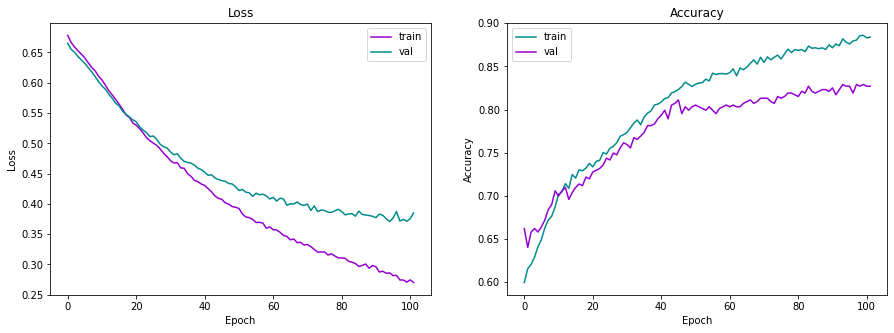

<Figure size 432x288 with 0 Axes>

In [87]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, c='darkviolet', label='train')
plt.plot(val_losses, c='darkcyan', label='val')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acces, c='darkcyan', label='train')
plt.plot(val_acces, c='darkviolet', label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.show()
plt.savefig("mygraph.png")

### 2-4. Model testing
- MLP로부터 chemical vector를 추출

In [156]:
# bitter taste compound of coffee: chlorogenic acid
# bitter taste compound of chocolate: methylxanthines
# bitter taste compound of coffee: mozambioside
# bitter taste compound of coffee: caffeine

custom_list = ['C1C(C(C(CC1(C(=O)O)O)OC(=O)C=CC2=CC(=C(C=C2)O)O)O)O', 'CN1C2=C(C(=O)NC1=O)NC=N2', 'CC12CC(=O)C3=C(C1CCC45C2C(CC(C4)C(C5)(CO)O)OC6C(C(C(C(O6)CO)O)O)O)C=CO3',
               'CN1C=NC2=C1C(=O)N(C(=O)N2C)C']
custom_y = [1 for i in range(len(custom_list))]
norm = True

In [ ]:
# sweet taste compound: aldehydes
# bitter taste compound of chocolate: methylxanthines
# bitter taste compound of coffee: mozambioside
# bitter taste compound of coffee: caffeine

custom_list = ['C(C(Cl)(Cl)Cl)(O)O']
custom_y = [1 for i in range(len(custom_list))]
norm = True

In [157]:
# make a list of QED values of molecules using RDKit
qed_list = []

for i in range(len(custom_list)):
    
    molecule = Chem.MolFromSmiles(custom_list[i])
    qed_list.append(Chem.QED.properties(molecule))

# make a dataframe of QED values
qed_df = pd.DataFrame(qed_list)
qed_df.head()

,MW,ALOGP,HBA,HBD,PSA,ROTB,AROM,ALERTS
0,354.311,-0.6459,9,6,164.75,4,1,3
1,166.140,-1.0501,3,2,83.54,0,2,0
2,508.564,0.0745,10,6,170.05,4,1,0
3,194.194,-1.0293,3,0,61.82,0,2,0


In [159]:
if norm:
    test_input = pd.DataFrame(normalize(qed_df, norm='l2', axis=0), columns=qed_df.columns)
    test_input = torch.tensor(test_input.values).float()
    print(test_input)
else:
    test_input = torch.tensor(qed_df.values).float()
    print(test_input)
test_input = torch.tensor(test_input).float()

tensor([[ 0.5285, -0.4017,  0.6380,  0.6882,  0.6371,  0.7071,  0.3162,  1.0000],
        [ 0.2478, -0.6531,  0.2127,  0.2294,  0.3231,  0.0000,  0.6325,  0.0000],
        [ 0.7586,  0.0463,  0.7089,  0.6882,  0.6576,  0.7071,  0.3162,  0.0000],
        [ 0.2897, -0.6402,  0.2127,  0.0000,  0.2391,  0.0000,  0.6325,  0.0000]])


/tmp/ipykernel_2672542/1524513523.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_input = torch.tensor(test_input).float()


In [160]:
chemical_vector, y_pred = model(test_input.to(device))
chemical_vector, y_pred

(tensor([[-3.1009e-01,  1.1796e+01,  2.7097e+00, -4.3998e-02, -6.3631e-01,
           1.0134e+01,  8.1247e-01,  7.2456e+00,  3.6716e-02, -3.2571e-01,
          -5.0943e-01, -4.0646e-01],
         [ 4.0019e+01,  1.5156e+01,  9.4195e+00,  2.5803e+01,  4.8998e+00,
           9.2167e+00,  9.8133e+00,  2.5307e+01,  5.7595e+00, -3.2571e-01,
           7.1635e+00, -4.0646e-01],
         [ 2.4149e+01,  1.4168e+01,  1.3892e+01,  6.3318e+01,  1.7510e+01,
           1.8283e+01,  2.2547e+01,  4.3769e+01,  4.6114e-03,  1.0312e+01,
           1.0073e+01, -4.0646e-01],
         [ 3.0120e+01,  1.4256e+01,  6.1904e+00,  1.1071e+01,  2.7087e+00,
           1.7458e+00,  3.5423e+00,  1.4722e+01,  4.6396e+00, -3.2571e-01,
           4.5236e+00, -2.7229e-01]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[0.0062],
         [1.0000],
         [1.0000],
         [1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>))

In [161]:
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
y_pred = y_pred.reshape(-1)
count = 0
for i in range(len(y_pred)):
    if y_pred[i] == custom_y[i]:
        count += 1
print(f'correct/total: {count}/{len(chemical_vector)}',)

correct/total: 3/4
